# Test downscaling

C:\Users\CLMRX\AppData\Local\Temp\1\ipykernel_201788\1264531973.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


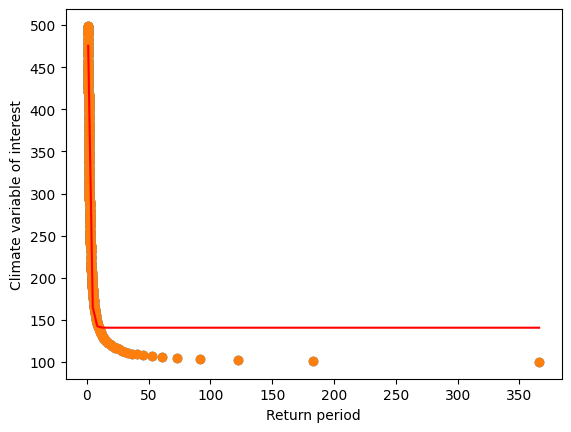

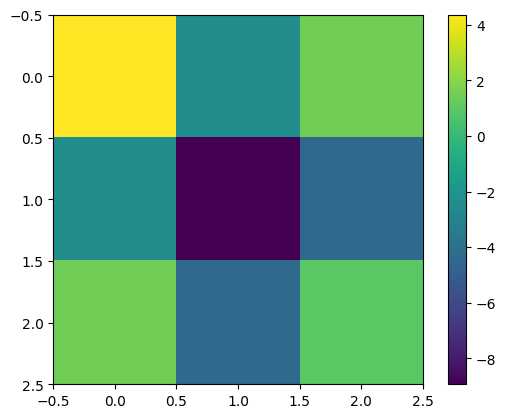

In [1]:
#Import python packages
from rasterstats import zonal_stats
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
import rioxarray #used when calling ncdata.rio.write_crs
import xarray as xr
import os
import os.path
import matplotlib.pyplot as plt
import netCDF4 as nc#not directly used but needs to be imported for some nc4 files manipulations, use for nc files
from netCDF4 import Dataset
import csv #REMOVE ? not in use ?
import numpy as np
import numpy.ma as ma
from mpl_toolkits.basemap import Basemap
import shutil # to move folders
import warnings
warnings.filterwarnings('ignore') # to ignore the warnings
#import io
import cdsapi # for copernicus function
import datetime # to have actual date
from osgeo import gdal, ogr, osr # in order to convert shp in raster
from geopandas import GeoDataFrame
from shapely.geometry import Point
from matplotlib.lines import Line2D

from FunctionsAndClass import read_cckp_ncdata
from FunctionsAndClass import get_cckp_file_name
from FileManagement import read_nc_file
from FileManagement import time_vector_conversion

#project locations (shapefile with location of elements to evaluate)
data_folder=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets'
#data_folder=os.path.join(os.pardir,'dataset')
project_location_path=os.path.join(data_folder,'Mozambique_PPIS/EIB_locations_few.shp')
project_id='Name' #name of column used as id

#study boundary (optional)
study_area_path=os.path.join(data_folder,'Mozambique_PPIS/mozambique.shp')

#output folder
#out_path=r'\\COWI.net\projects\A245000\A248363\CRVA\Scripts\outputs'
out_path=r'C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs'
out_path_database=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets'
#projection CRS (default = 'EPSG:4326')
bCRS='EPSG:4326'

#buffer for climate/grid variables
buffer=40000 #buffer in meters, 0 = no buffer is computed

mCRS='EPSG:31983' #metric CRS for buffer in meters (find relevant metric CRS for location!)



#### Pointwise models

In [2]:
# importing librairies and setting up
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")  # sklearn

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from utils import get_sample_data

sns.set(style='darkgrid')

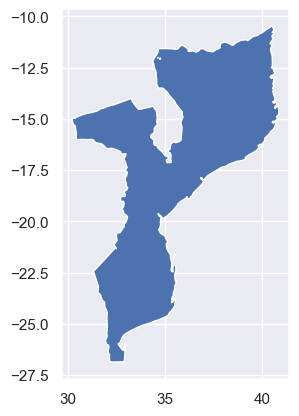

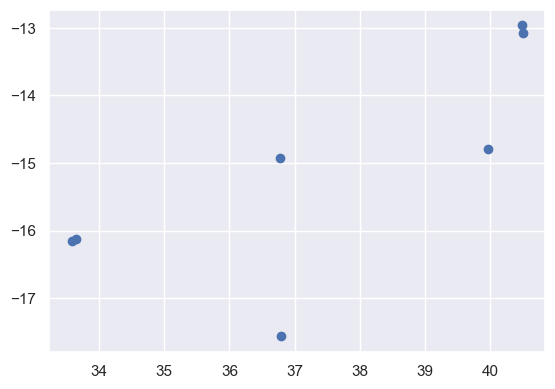

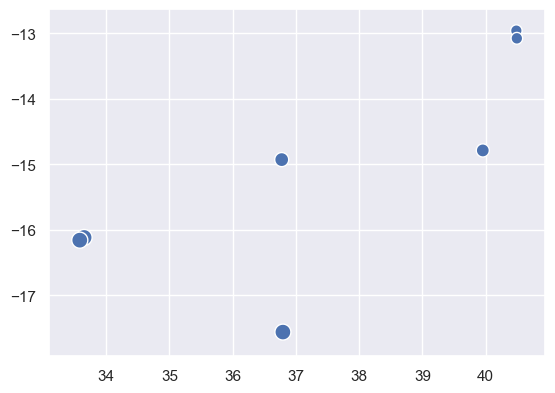

In [3]:
## load project information

#load shapefiles
projects = gpd.read_file(project_location_path).to_crs(bCRS)
study_area = gpd.read_file(study_area_path).to_crs(bCRS)

#calculate buffer around points/shape
if buffer != 0:
    projects_buf=projects.to_crs(mCRS)  #project to crs with metric units to get buffer in meters
    projects_buf['geometry']=projects.to_crs(mCRS).buffer(buffer) #assign the buffer as the new geometry - 
    projects_buf=projects_buf.to_crs(bCRS)#project back to orginal crs

    
#plot shapefiles
study_area.plot()
projects.plot()
projects_buf.plot() 


#show table
projects[[project_id]]

# register geographic information concerning projects
lon_projects = projects['geometry'].x
lat_projects = projects['geometry'].y
area_projects = [lat_projects - 5, lat_projects+5, lon_projects-5,lon_projects+5] # list format
# 5 degres trop grand 
#### determination of the geographical zone of interest 
lat_min_wanted = min(study_area['LAT'])-10
lat_max_wanted = max(study_area['LAT'])+10
lon_min_wanted = min(study_area['LON'])-20
lon_max_wanted = max(study_area['LON'])+20
# addind and substracting to lon and lat to have margin
# substracting more to longitude because the range of longitude is -180 to 180. The range of latitude is -90 to 90

area = [lat_min_wanted, lon_min_wanted, lat_max_wanted,lon_max_wanted,] # used to download from copernicus

### YEAR
first_year = 2025 # start year included
last_year = 2026 # last year included

year = np.arange(first_year,(last_year+1),1) # create vector of years
year_str = [0]*len(year) # create initiale empty vector to convert years in int
index = np.arange(0,len(year)) # create vector of index for year
i = 0 # initialize index
for i in index: # convert all the date in string format
    year_str[i]=str(year[i])

start_date = "01-01-"+year_str[0] # string start date based on start year
stop_date = "31-12-"+year_str[len(year)-1] # string stop date based on stop year
dates = pd.date_range(start_date,stop_date) # vector of dates between start date and stop date
index_dates = np.arange(0,len(dates)) # vector containning index o dates vector

## Upload data observation and correction

### Data to correct

In [4]:
path_train=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\temperature\Copernicus-CMIP6\daily_maximum_near_surface_air_temperature\PT_Revubue2(Rev201)\historical-1950-2014\monthly\download\tasmax_Amon_EC-Earth3-CC_historical_r1i1p1f1_gr_19500116-20141216_v20210113.nc'
(lat_train, lon_train, time_train, tasmax_train) = read_nc_file(path_train)
tasmax_train = tasmax_train -273.15 # convert tasmax from Kelvin to celsius degrees
time_str_train = time_vector_conversion(path_train,'monthly')
data_structure_train = xr.DataArray(tasmax_train, coords=[time_str_train,np.around(lat_train.astype('float32'),2),np.around(lon_train.astype('float32'),2)], dims=['time', 'lat','lon'])

In [5]:
data_structure_train_2014_project1=data_structure_train.loc['2014-01':'2014-12',:,:]

In [6]:
len(np.around(lat_train.astype('float32'),2))

71

### Observation data

In [7]:
# Observation data 
# from copernicus CRU, tasmax in degrees Celsius
#obs = Dataset(r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\Observations\temperature\global\1950-2019\monthly\0_5_x_0_5\cru\v4.03\CRU_maximum_temperature_mon_0.5x0.5_global_1950_v4.03.nc')
path_obs =r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\Observations\temperature\global\1950-2019\monthly\0_5_x_0_5\cru\v4.03\CRU_maximum_temperature_mon_0.5x0.5_global_2014_v4.03.nc'

In [8]:
# read data
(lat_obs, lon_obs, time_obs, tasmax_obs) = read_nc_file(path_obs)
time_str_obs = time_vector_conversion(path_obs,'daily')
# data for the whole world for the year 2014
data_structure_obs = xr.DataArray(tasmax_obs, coords=[time_str_obs,lat_obs,lon_obs], dims=['time', 'lat','lon'])

In [9]:
lat_obs_project1=lat_obs[lat_obs>min(lat_train)]
lat_obs_project1=lat_obs_project1[lat_obs_project1<max(lat_train)]
lon_obs_project1=lon_obs[lon_obs>min(lon_train)]
lon_obs_project1=lon_obs_project1[lon_obs_project1<max(lon_train)]

In [10]:
data_structure_obs_2014_project1=data_structure_obs.loc[:,lat_obs_project1,lon_obs_project1]

In [11]:
len(lon_obs_project1)

98

In [12]:
## FILLVALUE, Not working

from netCDF4 import Dataset
data = Dataset(path)
data.variables['tasmax']._FillValue

NameError: name 'path' is not defined

In [ ]:
data.variables['tasmax']

In [ ]:
# data to correct
path_train_data=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\temperature\Copernicus-CMIP6\daily_maximum_near_surface_air_temperature\PT_Revubue2(Rev201)\historical-1950-2014\monthly\tasmax_Amon_EC-Earth3-CC_historical_r1i1p1f1_gr_19500116-20141216_v20210113.nc'
(lat_train, lon_train, time_train, tasmax_train)  = read_nc_file(path_train_data)

In [ ]:
Dataset(path_train_data)

In [ ]:
os.path.isdir(path_train_data)

In [13]:
# dans 
# partie 1, BC
# partie 2, downscaling
# ligne les plus importante pour downscaling 

# on les donnees, on peut y aller. obs ceux de l'exemple ou bien copernicus. a corriger temp CMIP6 
from skdownscale.pointwise_models import PointWiseDownscaler # importation fonctionne
from skdownscale.pointwise_models import BcsdTemperature, BcsdPrecipitation # importation fonctionne
#from dask.diagnostics import ProgressBar

model = PointWiseDownscaler(BcsdTemperature(return_anoms=False)) # fonctioonne
model
#model.fit(data_structure_train_2014_project1, data_structure_obs_2014_project1) # train subset and obs_subset are xarray.DataArray 'tasmax'
#display(model, model._models)

<skdownscale.PointWiseDownscaler>
  Fit Status: False
  Model:
    BcsdTemperature(return_anoms=False)

In [14]:
predicted = model.predict(data_structure_train_2014_project1).load()
display(predicted)
predicted.isel(time=0).plot()

AttributeError: 'NoneType' object has no attribute 'dims'

In [15]:
type(data_structure_train_2014_project1)

xarray.core.dataarray.DataArray

In [16]:
type(model)

skdownscale.pointwise_models.core.PointWiseDownscaler

In [ ]:
# ne fonctionne pas car il faut entrainer le model et il faut faire ca avec des set de data des dimensions similaire
# test avec ce qu'ils font dans le code d'origine

In [17]:
# parameters
train_slice = slice('1980', '1982')  # train time range
holdout_slice = slice('1990', '1991')  # prediction time range

# bounding box of downscaling region
lon_slice = slice(lon_min_wanted, lon_max_wanted) 
lat_slice = slice(lat_min_wanted, lat_max_wanted)

# chunk shape for dask execution (time must be contiguous, ie -1)
chunks = {'lat': 10, 'lon': 10, 'time': -1}

In [18]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 15.71 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:49865,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.71 GiB
Comm: tcp://127.0.0.1:49891,Total threads: 2
Dashboard: http://127.0.0.1:49896/status,Memory: 3.93 GiB
Nanny: tcp://127.0.0.1:49868,


In [21]:
import xarray as xr

fnames = [f'http://thredds.northwestknowledge.net:8080/thredds/dodsC/MET/tmmx/tmmx_{year}.nc'
          for year in range(int(train_slice.start), int(train_slice.stop) + 1)]
# open the data and cleanup a bit of metadata
obs = xr.open_mfdataset(fnames, engine='pydap', concat_dim='day',combine = 'nested').rename({'day': 'time'}).drop('crs')
# added combine = 'nested'

### PROBLEM: does not work, because of URL, not valid anymore

obs_subset = obs['air_temperature'].sel(time=train_slice, lon=lon_slice, lat=lat_slice).resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

# display
display(obs_subset)
obs_subset.isel(time=0).plot()

HTTPError: 400 Bad Request
Error {
    code = 5;
    message = "Illegal index for range last index";
};


In [ ]:
# use datat of PANGEO ?? que acces payant

In [ ]:
 # essayer de rouver des donnes avce la meme resolution
    # pour le model, piste ERA 5 a comparer avec autre, il faut la meme resolution